## 라이브러리 호출

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.stats as stats

In [2]:
from sklearn.pipeline import make_pipeline # pipeline
from sklearn.compose import make_column_transformer # 문자는 문자, 숫자는 숫자끼리 처리
from sklearn.impute import SimpleImputer # 단순 대치(대표값)
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# 특성 공학

- 5가지 특성 공학 기법
1. Imputation (결측값 대치) : 결측값(공백)이 있는 위치에 다른 값으로 대치
    - 연속형 (숫자)
        - 평균, 중앙값과 같은 대표값으로 대치
        - 알고리즘을 이용해 대치 (KNN)
        
        <br>
    - 범주형 (문자)
        - 최빈값과 같은 대표값으로 대치
        - 결측값 자체를 하나의 `미상` 또는 `Unknown`으로 대치
        
        <br>
2. Scaling & Encoding :
    - Scaling : 연속형 자료의 Scale을 맞추는 기법 (회귀분석 알고리즘)
    > ex) 가격 : 1,000 ~ 2,000,000 | 연령 : 20 ~ 80
        - `Standard Scaling` : 정규화 (평균 0, 표준편차1)
        - `MinMax Scaling` : 표준화 (최소 0, 최대 1) >> 일반적으로 범주형 항목이 많은 경우
        - `Robust Scaling` : (중앙 0, IQR 1) >> 일반적으로 이상치가 많을 경우 사용
        
        <br>
    - Encoding : 문자데이터를 숫자 형태로 변환
        - `Label Encoding` : 문자 항목을 특정 정수로 변환 (데이터간 서열이 발생 할 수 있음)
        - `One Hot Encoding` : 문자 항목을 0/1로 구분하는 Column을 만들어 변환

- Pipeline : 특성공학 + 학습 동시에 수행

## '연체건수'(Overdue_count)를 예측하는 모델을 구성하고자 한다. 아래의 조건에 맞게 Model 생성
1. X : 'Age', 'Term','Amount_Month'
2. Y : 'Overdue_count'
3. Train : Test = 8 : 2
4. DecisionTreeRegressor 알고리즘
5. 평가 : 학습데이터의 R2와 테스트 데이터의 R2를 계산


##### 1. 데이터 불러오기

In [3]:
df1 = pd.read_csv('./data/01_Data.csv')

##### 2. 설명변수와 목표변수 설정

In [4]:
X = df1[['Age','Gender','Amount_Month','Term','Product_Type','Credit_Rank']]
Y = df1['Overdue_count']

##### 3. 데이터 분할

In [5]:
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size = 0.2, random_state=42)

##### 4. 연속형과 범주형을 처리하는 pipeline 생성

In [6]:
# 숫자데이터 처리되는 pipe 생성 (평균 대치, MinMaxSacling)
numeric_pipe = make_pipeline(SimpleImputer(strategy='mean'),
                             MinMaxScaler())

# 문자데이터 처리되는 pipe 생성 (최빈값 대치, OneHotEncoding)
category_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'),
                             OneHotEncoder())

##### 5. 문자와 숫자를 각각 처리할 수 있는 pipe 생성

In [7]:
preprocessing_pipe = make_column_transformer((numeric_pipe, ['Age','Amount_Month','Term','Credit_Rank']),
                                            ((category_pipe), ['Gender','Product_Type']))
preprocessing_pipe

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['Age', 'Amount_Month', 'Term',
                                  'Credit_Rank']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder())]),
                                 ['Gender', 'Product_Type'])])

##### 6. 학습 모델 구성

In [8]:
model_pipe = make_pipeline(preprocessing_pipe, DecisionTreeRegressor())
model_pipe.fit(x_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['Age', 'Amount_Month',
                                                   'Term', 'Credit_Rank']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  ['Gender',
                                                   'Product_Type'])])),
                ('decisiontreeregressor', DecisionTreeRegressor())])

##### 7. 모델 평가

In [9]:
def evaluation_regressor(model):
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    print(f'Train set의 r2_score : {r2_score(y_train, y_train_pred)}')
    print(f'Test set의 r2_score : {r2_score(y_test, y_test_pred)}')
    
    print(f'Train set의 RMSE : {np.sqrt(mean_squared_error(y_train, y_train_pred))}')
    print(f'Test set의 RMSE : {np.sqrt(mean_squared_error(y_test, y_test_pred))}')


evaluation_regressor(model_pipe)

Train set의 r2_score : 0.5892237706638439
Test set의 r2_score : -0.2347213942753228
Train set의 RMSE : 0.6971189360243014
Test set의 RMSE : 1.3892615015123393


##### 8. 새로운 데이터로 예측

In [10]:
x1 = input('고객의 연령을 입력하시오 : ')
print(df1['Gender'].unique())
x2 = input('고객의 성별을 입력하시오 : ')
x3 = input('월 계약비용을 입력하시오 : ')
x4 = input('총 계약 기간을 입력하시오 : ')
print(df1['Product_Type'].unique())
x5 = input('제품군을 입력하시오 : ')
x6 = input('고객의 신용등급을 입력하시오 : ')

고객의 연령을 입력하시오 : 30
['여자' '남자']
고객의 성별을 입력하시오 : 남자
월 계약비용을 입력하시오 : 100000
총 계약 기간을 입력하시오 : 12
['DES-1' 'DES-3A' 'DES-2' 'DES-R4' 'MMC' 'ERA']
제품군을 입력하시오 : DES-1
고객의 신용등급을 입력하시오 : 9


In [11]:
input_data = pd.DataFrame(data = [[x1,x2,x3,x4,x5,x6]], 
                          columns = ['Age','Gender','Amount_Month','Term','Product_Type','Credit_Rank'])
input_data

,Age,Gender,Amount_Month,Term,Product_Type,Credit_Rank
0,30,남자,100000,12,DES-1,9


In [12]:
model_pipe.predict(input_data)

array([9.5])

- input_data에서 만약 결측치가 있다면 data값 자체를 np.nan으로 설정한다.
```python
input_data = pd.DataFrame(data = [[x1,np.nan,x3,x4,x5,x6]], 
                          columns = ['Age','Gender','Amount_Month','Term','Product_Type','Credit_Rank'])
```

[처음으로 돌아가기](#라이브러리-호출)

---

# 플라스틱 설비 데이터 

In [13]:
df_detect = pd.read_csv('./data/09_Detection.csv')
df_process = pd.read_csv('./data/09_Process_A.csv')

In [14]:
display(df_detect.head(2))
display(df_process.head(2))

,Unnamed: 0,date_clean,tag,tag_num,unit,Y1A,Y2A,Y3A
0,0,2018-12-01 03:30:00.000,NE280V,GO1701,Total [1/m²],4954.774,327.416,256.882
1,1,2018-12-01 07:30:00.005,NE280PV,GO1701,Total [1/m²],2281.460,44.410,17.416


,Unnamed: 0.1,Unnamed: 0,DATE,PERIOD,Label,A1,A2,A3,A4,A5,A6
0,0,0,2018-12-01T00:10:00,P1,AVG,225.637279,228.533316,230.788205,230.634245,232.112927,230.630909
1,1,1,2018-12-01T00:20:00,P1,AVG,225.763044,228.519014,230.428961,230.936762,231.899435,230.564272


In [15]:
df_detect.info()
df_process.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 474 entries, 0 to 473
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  474 non-null    int64  
 1   date_clean  474 non-null    object 
 2   tag         474 non-null    object 
 3   tag_num     474 non-null    object 
 4   unit        474 non-null    object 
 5   Y1A         474 non-null    float64
 6   Y2A         474 non-null    float64
 7   Y3A         474 non-null    float64
dtypes: float64(3), int64(1), object(4)
memory usage: 29.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10656 entries, 0 to 10655
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0.1  10656 non-null  int64  
 1   Unnamed: 0    10656 non-null  int64  
 2   DATE          10656 non-null  object 
 3   PERIOD        10656 non-null  object 
 4   Label         10656 non-null  object 
 5   A1      

##### 날짜 데이터 변환
##### Pandas 시간 단위
- s : 초
- T : 분
- H : 시간
- D: 일
- B : 평일
- W : 주(일요일 기준)
- W-MON : 주(월요일 기준)
- M : 월(30일 기준)
- MS : 월(달의 마지막 날)

In [16]:
df_detect['Datetime'] = pd.to_datetime(df_detect['date_clean'])
df_process['Datetime'] = pd.to_datetime(df_process['DATE'])

display(df_detect[['Datetime']], df_process[['Datetime']])

,Datetime
0,2018-12-01 03:30:00.000
1,2018-12-01 07:30:00.005
2,2018-12-01 11:30:00.010
3,2018-12-01 15:30:00.015
4,2018-12-01 19:30:00.020
...,...
469,2019-09-03 15:30:00.000
470,2019-09-03 18:30:00.000
471,2019-09-03 19:30:00.000
472,2019-09-03 23:30:00.000


,Datetime
0,2018-12-01 00:10:00
1,2018-12-01 00:20:00
2,2018-12-01 00:30:00
3,2018-12-01 00:40:00
4,2018-12-01 00:50:00
...,...
10651,2019-09-03 23:20:00
10652,2019-09-03 23:30:00
10653,2019-09-03 23:40:00
10654,2019-09-03 23:50:00


##### Pandas 시간 단위
- s : 초
- T : 분
- H : 시간
- D: 일
- B : 평일
- W : 주(일요일 기준)
- W-MON : 주(월요일 기준)
- M : 월(30일 기준)
- MS : 월(달의 마지막 날)

In [17]:
# 시간 단위가 초단위에 정확하게 맞아 떨어지지 않음 ! -> 시간을 분단위로 반올림
df_detect['Datetime_T'] = df_detect['Datetime'].round('T')

In [18]:
# 설비 데이터와 병합 시, 앞 뒤 시간에 따른 데이터의 특성을 반영하기 위해
# 30분 단위로, A1에서 A6까지 자료를 통계량으로 계산하여 병합

# 데이터를 30분 단위로 중앙값을 계산해 구성
# 1. Datetime의 컬럼을 인덱스로 가져옴 -> set_index
# 2. 30분 단위로 가져옴 -> resampel('30T')
# 3. 그 중 중앙값을 가져옴 -> .median()
df_process_30T = df_process.set_index('Datetime').resample('30T').median()

# 다시 인덱스인 Datetime에서 reset_index를 해줌
df_process2 = df_process_30T.reset_index()

C:\Users\admin\AppData\Local\Temp\ipykernel_25364\793635645.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_process_30T = df_process.set_index('Datetime').resample('30T').median()


In [19]:
df1 = pd.merge(df_detect, df_process2,
               left_on = 'Datetime_T', right_on = 'Datetime', how='inner')
df1.head(10)

,Unnamed: 0_x,date_clean,tag,tag_num,unit,Y1A,Y2A,Y3A,Datetime_x,Datetime_T,Datetime_y,Unnamed: 0.1,Unnamed: 0_y,A1,A2,A3,A4,A5,A6
0,0,2018-12-01 03:30:00.000,NE280V,GO1701,Total [1/m²],4954.774,327.416,256.882,2018-12-01 03:30:00.000,2018-12-01 03:30:00,2018-12-01 03:30:00,21.0,21.0,224.686050,227.440741,229.780665,229.752830,230.934634,229.514491
1,1,2018-12-01 07:30:00.005,NE280PV,GO1701,Total [1/m²],2281.460,44.410,17.416,2018-12-01 07:30:00.005,2018-12-01 07:30:00,2018-12-01 07:30:00,45.0,45.0,225.881809,228.579524,230.934893,231.026156,231.873045,230.441799
2,2,2018-12-01 11:30:00.010,NE280V,GO1701,Total [1/m²],4453.201,74.017,23.511,2018-12-01 11:30:00.010,2018-12-01 11:30:00,2018-12-01 11:30:00,69.0,69.0,228.100989,229.933238,231.071409,230.426619,230.495147,228.806310
3,3,2018-12-01 15:30:00.015,NE280PV,GO1701,Total [1/m²],4352.190,77.500,37.444,2018-12-01 15:30:00.015,2018-12-01 15:30:00,2018-12-01 15:30:00,93.0,93.0,228.391907,229.853701,230.969399,230.321498,230.188089,228.399797
4,4,2018-12-01 19:30:00.020,NE280V,GO1701,Total [1/m²],4345.224,62.697,40.927,2018-12-01 19:30:00.020,2018-12-01 19:30:00,2018-12-01 19:30:00,117.0,117.0,229.209428,230.289857,230.993988,230.148035,229.526814,227.565878
5,5,2018-12-01 23:30:00.025,NE280PV,GO1701,Total [1/m²],5277.970,92.236,50.037,2018-12-01 23:30:00.025,2018-12-01 23:30:00,2018-12-01 23:30:00,141.0,141.0,228.252992,229.242930,229.978670,229.152936,228.471310,226.574908
6,6,2018-12-02 03:30:00.030,NE280PV,GO1701,Total [1/m²],4944.857,101.093,51.477,2018-12-02 03:30:00.030,2018-12-02 03:30:00,2018-12-02 03:30:00,165.0,165.0,228.126892,229.163713,230.025932,229.019995,228.463202,226.522164
7,7,2018-12-02 07:30:00.035,NE280V,GO1701,Total [1/m²],5249.100,133.230,71.404,2018-12-02 07:30:00.035,2018-12-02 07:30:00,2018-12-02 07:30:00,189.0,189.0,229.201458,230.179097,230.985865,229.849191,229.194001,227.148445
8,8,2018-12-02 11:30:00.040,NE280PV,1701,Total [1/m²],5265.144,130.749,65.374,2018-12-02 11:30:00.040,2018-12-02 11:30:00,2018-12-02 11:30:00,213.0,213.0,228.342932,229.189135,229.985444,229.015941,228.192751,226.199432
9,9,2018-12-02 15:30:00.045,NE280V,1701,Total [1/m²],4878.145,95.786,41.798,2018-12-02 15:30:00.045,2018-12-02 15:30:00,2018-12-02 15:30:00,237.0,237.0,227.077185,228.192454,228.979210,228.392300,227.691444,225.855561


# 관리도(Control Chart) 
- 관리도 : 공정이나 품질에서 발생하는 데이터의 이상치를 확인하고, 빠르게 조치하기 위해 사용하는 시각화 기법
- 품질 변동 원인 (품질 불량을 일으키는 원인)
    - 우연 원인 : 피치못할 원인 (어쩔수 없는 원인, 통제가 불가능 한 원인)
    - 이상 원인 : 통제 가능한 원인
- 이상상태 (Out of Control : 특정 요인에 의해 공정에서 지속적으로 이상치가 발생하는 상태)를 통제 가능한 원인(이상 원인)에서 빠르게 파악하는 작업을 관리도로 확인

<br>

- 관리도의 종류
    - 계량치 관리도 (실수 형태로 표현 가능한 연속형 숫자 - 계량치, 온도, 습도, 압력 ...)
        - XBar-R : 평균과 범위(최소값-최대값)를 이용
        - Xbar-σ : 평균과 표준편차를 이용해 시각화
    - 계수치 관리도 (정수 형태로 표현 가능한 연속형 데이터 - 불량 개수, 단위 면적 당 결점 수)
        - P 관리도 (불량률)
        - C 관리도 (결점수)\
        ...

In [20]:
# XBar-σ 관리도
# 중심선 : 데이터의 대표값 (평균)
# n시그마 기준 ->  표준편차의 n배
# 관리 상한선 (UCL / Upper Control Limit): 평균에서 위로 표준편차에 3배 해당하는 부분
# 관리 하한선 (LCL / Lower Control Limit): 평균에서 아래로 표준편차에 3배 해당하는 부분
# 공정관리(Statistical Process Control,SPC)에서 주로 쓰임

df1_top = df1.head(50)

In [21]:
center = df1_top['A1'].mean()
UCL    = center + (df1_top['A1'].std() * 3)
LCL    = center - (df1_top['A1'].std() * 3)

In [22]:
# 인덱스를 하나의 데이터로 가져와서 사용
df1_A_cc = df1_top[['A1']].reset_index()
df1_A_cc['Center'] = center
df1_A_cc['UCL'] = UCL
df1_A_cc['LCL'] = LCL
df1_A_cc

,index,A1,Center,UCL,LCL
0,0,224.686050,229.098391,233.204284,224.992497
1,1,225.881809,229.098391,233.204284,224.992497
2,2,228.100989,229.098391,233.204284,224.992497
3,3,228.391907,229.098391,233.204284,224.992497
4,4,229.209428,229.098391,233.204284,224.992497
5,5,228.252992,229.098391,233.204284,224.992497
6,6,228.126892,229.098391,233.204284,224.992497
7,7,229.201458,229.098391,233.204284,224.992497
8,8,228.342932,229.098391,233.204284,224.992497
9,9,227.077185,229.098391,233.204284,224.992497


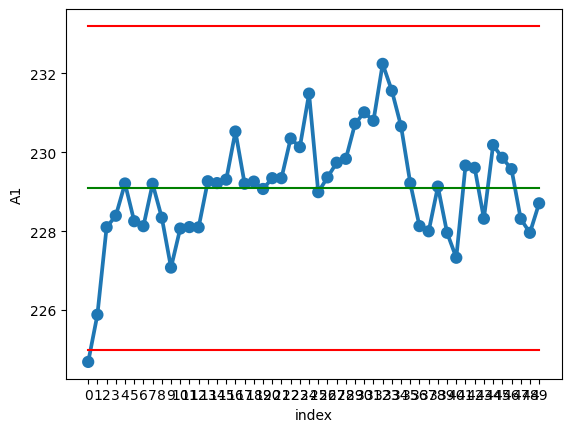

In [23]:
sns.pointplot(data=df1_A_cc, x='index', y='A1')
sns.lineplot(data=df1_A_cc, x='index', y='Center', color = 'g')
sns.lineplot(data=df1_A_cc, x='index', y='UCL', color = 'r')
sns.lineplot(data=df1_A_cc, x='index', y='LCL', color = 'r')
plt.show()

[처음으로 돌아가기](#라이브러리-호출)

---

In [24]:
df1 = pd.read_csv('./data/01_Data.csv')
df1['State'].unique()

array(['계약확정', '기간만료', '해약확정', '해약진행중'], dtype=object)

In [25]:
df1['Target'] = df1['State'].replace({'계약확정': 0, '기간만료' : 1, '해약확정' : 1, '해약진행중' : 1})

In [26]:
X = df1[['Age','Gender','Credit_Rank','Amount_Month','Term','Product_Type']]
Y = df1['Target']

In [27]:
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.3, random_state=42)

In [28]:
# 교차검증과 Hyper Parameter 라이브러리 호출
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

In [29]:
# Pipeline
numeric_pip = make_pipeline(SimpleImputer(strategy = 'median'), MinMaxScaler())
category_pip = make_pipeline(SimpleImputer(strategy = 'most_frequent'), OneHotEncoder())

numeric_list = X.select_dtypes(exclude = 'object').columns
category_list = X.select_dtypes(include = 'object').columns
preprocessing_pipe = make_column_transformer( (numeric_pipe, numeric_list),
                                            (category_pipe, category_list))
display(preprocessing_pipe)

model_pipe = make_pipeline(preprocessing_pipe, DecisionTreeClassifier())
display(model_pipe)

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 Index(['Age', 'Credit_Rank', 'Amount_Month', 'Term'], dtype='object')),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder())]),
                                 Index(['Gender', 'Product_Type'], dtype='object'))])

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  Index(['Age', 'Credit_Rank', 'Amount_Month', 'Term'], dtype='object')),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  Index(['Gender', 'Product_Type'], dtype='object'))])),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

In [30]:
grid_model = GridSearchCV(model_pipe,
                          param_grid = {'decisiontreeclassifier__min_samples_split' : range(5,30)},
                          cv=5, # Fold
                          scoring= 'f1', # f1_score
                         n_jobs = -1) # 내 컴퓨터 cpu의 core를 병렬로 할당 계산 : 병렬 처리
# 교차검증 Fold : 5
# 하이퍼파라미터 range(5,30) -> 25개
# 5 * 25 = 125
grid_model.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('minmaxscaler',
                                                                                          MinMaxScaler())]),
                                                                         Index(['Age', 'Credit_Rank', 'Amount_Month', 'Term'], dtype='object')),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder())]),
                                                                         Index(['Gender', 'Product_Type'], dtype='object'))])),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'decisiontreeclassifier__min_samples_split': range(5, 30)},
             scoring='f1')

In [31]:
best_model = grid_model.best_estimator_
best_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  Index(['Age', 'Credit_Rank', 'Amount_Month', 'Term'], dtype='object')),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  Index(['Gender', 'Product_Type'], dtype='object'))])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(min_samples_split=7))])

In [32]:
def evaluation_classifier(model):
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

#     print(classification_report(y_train,y_train_pred))
#     print(classification_report(y_test,y_test_pred))
    
    report_train = classification_report(y_train, y_train_pred, output_dict=True)
    res_train = pd.DataFrame(report_train).T
    
    report_test = classification_report(y_test, y_test_pred, output_dict=True)
    res_test = pd.DataFrame(report_test).T
    display(res_train)
    display(res_test)

evaluation_classifier(best_model)

,precision,recall,f1-score,support
0,0.987342,0.999774,0.993519,35422.000000
1,0.809524,0.069672,0.128302,488.000000
accuracy,0.987135,0.987135,0.987135,0.987135
macro avg,0.898433,0.534723,0.560911,35910.000000
weighted avg,0.984926,0.987135,0.981762,35910.000000


,precision,recall,f1-score,support
0,0.987691,0.997829,0.992734,15198.000000
1,0.108108,0.020725,0.034783,193.000000
accuracy,0.985576,0.985576,0.985576,0.985576
macro avg,0.547899,0.509277,0.513758,15391.000000
weighted avg,0.976661,0.985576,0.980721,15391.000000


---

# Mission 8
- '09_Data.csv'를 가져와 df2로 선언뒤 아래의 미션 수행

In [33]:
df2 = pd.read_csv('./data/09_Data.csv')

In [34]:
# 1. df2에 'tag'항목의 빈도수 확인
df2['tag'].value_counts()

NE280PV    373
NE282PV     74
NE280V      13
E280PV      13
Name: tag, dtype: int64

In [35]:
# 2. df2에서 'Y1A'에서 3000이상인 값을 추출하여, 높은 순서대로 정렬 후 상위 300개 데이터를 뽑아 'A1'값의 평균 계산
df2[df2['Y1A'] >= 3000].sort_values(by = 'Y1A', ascending = False).head(300)['A1'].mean()

228.1683534250534

In [36]:
# 3. df2에서 'Datetime_T'항목에서 '연도'/'월'/'일'/'날짜' 항목을 추출하고, 18년도 대비 19년도의 'Y1A'값의 증감율 계산
df2['연도'] = pd.to_datetime(df2['Datetime_T']).dt.year
df2['월'] = pd.to_datetime(df2['Datetime_T']).dt.month
df2['일'] = pd.to_datetime(df2['Datetime_T']).dt.day
df2['날짜'] = pd.to_datetime(df2['Datetime_T']).dt.date
df2[['연도','월','일','날짜']]

,연도,월,일,날짜
0,2018,12,1,2018-12-01
1,2018,12,1,2018-12-01
2,2018,12,1,2018-12-01
3,2018,12,1,2018-12-01
4,2018,12,1,2018-12-01
...,...,...,...,...
468,2019,9,3,2019-09-03
469,2019,9,3,2019-09-03
470,2019,9,3,2019-09-03
471,2019,9,3,2019-09-03


In [37]:
pivot_q3 = df2.pivot_table(index = '연도', values = 'Y1A', aggfunc = 'sum')
display(pivot_q3)
(pivot_q3['Y1A'][2019] - pivot_q3['Y1A'][2018]) / pivot_q3['Y1A'][2018]

,Y1A
연도,
2018,1605981.111
2019,2880489.628


0.7936011876294103

In [38]:
# 4. '날짜'별 'Y1A'의 합을 아래와 같이 계산
df2.pivot_table(index = '날짜', values = 'Y1A', aggfunc = 'sum').T

# 또는 
# df2.pivot_table(columns = '날짜', values = 'Y1A', aggfunc = 'sum')

날짜,2018-12-01,2018-12-02,2018-12-03,2018-12-04,2018-12-05,2018-12-06,2018-12-07,2018-12-08,2018-12-18,2018-12-19,...,2019-08-25,2019-08-26,2019-08-27,2019-08-28,2019-08-29,2019-08-30,2019-08-31,2019-09-01,2019-09-02,2019-09-03
Y1A,25664.819,31498.954,39239.242,59119.993,80022.696,64206.174,58847.107,57969.619,87204.996,83119.33,...,22657.564,27938.248,24552.891,46335.53,37774.848,53298.433,34983.723,26600.331,41972.167,185864.353


In [39]:
# 5. 'tag'항목에서 NE282PV항목을 추출하여, '날짜'별 A1 ~ A6값의 평균을 계산하여 df_clean_day로 선언
df2_q5 = df2.loc[df2['tag'] == 'NE282PV']
df_clean_day = df2_q5.pivot_table(index='날짜', values = ['A1','A2','A3','A4','A5','A6'], aggfunc = 'mean')
df_clean_day

,A1,A2,A3,A4,A5,A6
날짜,,,,,,
2018-12-31,229.609414,230.695662,231.757827,230.572758,230.031477,228.043440
2019-01-14,230.812607,232.079659,232.995741,232.103749,231.611072,229.538100
2019-01-15,230.930781,231.906625,233.003474,231.607915,231.052513,228.948110
2019-01-16,229.747781,230.839507,232.007999,230.727205,230.226346,228.096134
2019-01-17,231.304458,232.265158,232.978176,231.916919,231.200353,229.098361
2019-01-19,229.207820,232.196454,234.388567,234.216976,234.556925,232.743752
2019-01-20,226.159240,229.417018,232.016727,232.167949,233.013053,231.310107
2019-01-21,231.333092,233.711908,235.505608,234.865738,234.617371,232.628766
2019-01-25,229.657478,231.451127,233.072890,232.354244,232.233752,230.275463


In [40]:
# 6. df_clean_day 데이터에서, A1 값에 대한, Xbar-σ관리도를 시각화
df2_q6 = df_clean_day.reset_index().reset_index()
center = df2_q6['A1'].mean()
UCL    = center + (df2_q6['A1'].std() * 3)
LCL    = center - (df2_q6['A1'].std() * 3)

# 인덱스를 하나의 데이터로 가져와서 사용
df2_q6['Center'] = center
df2_q6['UCL'] = UCL
df2_q6['LCL'] = LCL
df2_q6

,index,날짜,A1,A2,A3,A4,A5,A6,Center,UCL,LCL
0,0,2018-12-31,229.609414,230.695662,231.757827,230.572758,230.031477,228.043440,230.709761,238.206857,223.212664
1,1,2019-01-14,230.812607,232.079659,232.995741,232.103749,231.611072,229.538100,230.709761,238.206857,223.212664
2,2,2019-01-15,230.930781,231.906625,233.003474,231.607915,231.052513,228.948110,230.709761,238.206857,223.212664
3,3,2019-01-16,229.747781,230.839507,232.007999,230.727205,230.226346,228.096134,230.709761,238.206857,223.212664
4,4,2019-01-17,231.304458,232.265158,232.978176,231.916919,231.200353,229.098361,230.709761,238.206857,223.212664
5,5,2019-01-19,229.207820,232.196454,234.388567,234.216976,234.556925,232.743752,230.709761,238.206857,223.212664
6,6,2019-01-20,226.159240,229.417018,232.016727,232.167949,233.013053,231.310107,230.709761,238.206857,223.212664
7,7,2019-01-21,231.333092,233.711908,235.505608,234.865738,234.617371,232.628766,230.709761,238.206857,223.212664
8,8,2019-01-25,229.657478,231.451127,233.072890,232.354244,232.233752,230.275463,230.709761,238.206857,223.212664
9,9,2019-01-26,229.799361,231.567005,233.160347,232.267593,232.103274,230.200065,230.709761,238.206857,223.212664


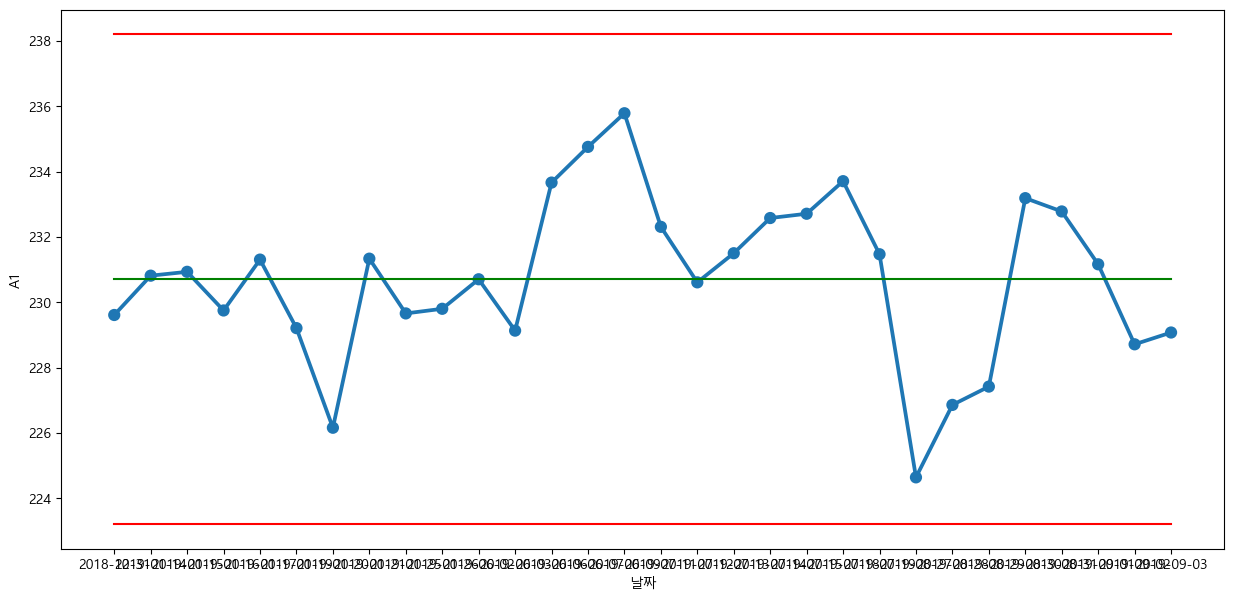

In [41]:
mpl.rc('font', family = 'Malgun Gothic')
plt.figure(figsize = (15,7))
sns.pointplot(data=df2_q6, x='날짜', y='A1')
sns.lineplot(data=df2_q6, x='index', y='Center', color = 'g')
sns.lineplot(data=df2_q6, x='index', y='UCL', color = 'r')
sns.lineplot(data=df2_q6, x='index', y='LCL', color = 'r')
plt.show()

In [42]:
# 7. df2에서 'tag'항목에서 NE280PV 와 NE282PV 두 집단의 A1값의 평균의 차이가 있는지 가설검정을 수행 

df2_q7 = df2.loc[df2['tag'].isin(['NE280PV','NE282PV'])]
df2_280 = df2.loc[df2['tag'] == 'NE280PV']
df2_282 = df2.loc[df2['tag'] == 'NE282PV']

# 1) 정규성 검정
# H0 : A1의 분포는 정규성을 따른다.
# H1 : A1의 분포는 정규성을 따르지 않는다.
stats.normaltest(df2_q7['A1'].dropna())
# p-value > 0.05 이므로 H0 채택
# 따라서 A1분포는 정규성을 따른다.

NormaltestResult(statistic=0.5967772183504292, pvalue=0.7420129306792091)

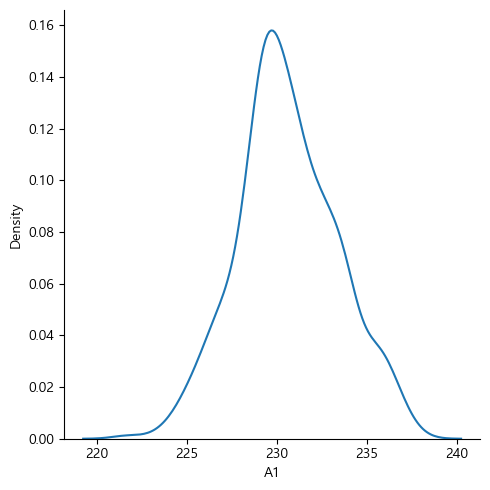

In [43]:
sns.displot(data=df2_q7, x='A1', kind='kde')

In [44]:
# 2) 등분산성 검정
# H0 : 두 집단의 분산은 같다.
# H0 : 두 집단의 분산은 다르다.
stats.bartlett(df2_280['A1'].dropna(), df2_282['A1'].dropna())
# p-value > 0.05 이므로 H0 채택
# 따라서 두 집단의 분산은 같다고 볼 수 있다.

BartlettResult(statistic=1.83124279593483e-08, pvalue=0.9998920275329178)

In [45]:
# 3) 평균 검정(이분산)
# H0 : 두 집단의 평균은 같다
# H1 : 두 집단의 평균은 다르다
stats.ttest_ind(df2_280['A1'].dropna(), df2_282['A1'].dropna(), equal_var=False)
# p-value > 0.05 이므로 H0 채택
# 따라서 두 집단의 평균은 같다고 볼 수 있다.

Ttest_indResult(statistic=-0.37755307820105555, pvalue=0.7065296336569206)

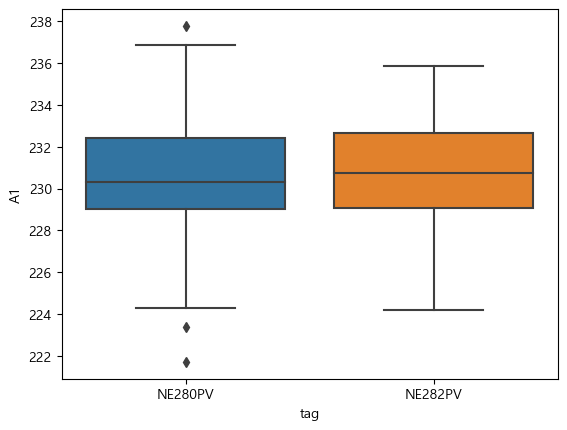

In [46]:
sns.boxplot(data=df2_q7, x='tag', y='A1')
plt.show()

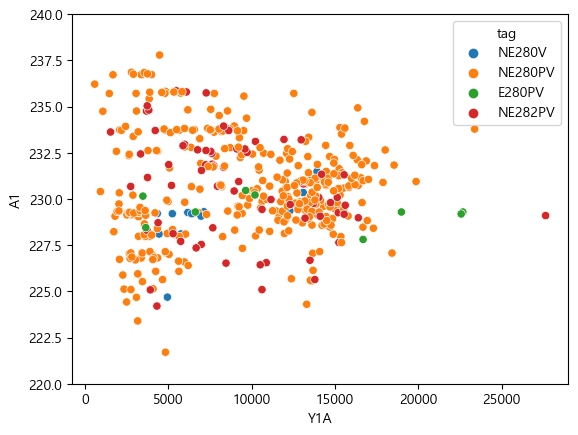

In [47]:
# 8. 'Y1A'값과 'A1'값의 산점도를 'tag'에 따라 색상을 나누어 시각화하고, 두 연속형 데이터가 상관성이 있는지 가설검정을 수행 
sns.scatterplot(data=df2, x='Y1A', y='A1', hue = 'tag')
plt.ylim(220,240)
plt.show()

In [48]:
# 1) 정규성 검정
# H0 : 데이터의 분포는 정규성을 따른다.
# H1 : 데이터의 분포는 정규성을 따르지 않는다.
df2_q8 = df2.dropna()
print('Y1A 의 p-value 값은 :',stats.normaltest(df2_q8['Y1A'])[1])
print('A1 의 p-value 값은 :',stats.normaltest(df2_q8['A1'])[1])

# 두 데이터 모두 p-value < 0.05이므로 H0 기각
# 따라서 두 데이터 모두 정규성을 따르지 않는다

Y1A 의 p-value 값은 : 2.0623738973377755e-07
A1 의 p-value 값은 : 2.291432723526567e-178


In [49]:
# 2) 상관분석
# H0 : Y1A와 A1는 서로 상관성이 없다.
# H1 : Y1A와 A1는 서로 상관성이 있다.
stats.spearmanr(df2_q8['Y1A'], df2_q8['A1'].dropna())
# p-value > 0.05 이므로 H0 채택
# 따라서 두 데이터는 서로 상관성이 없다고 볼 수 있다.

SpearmanrResult(correlation=0.020357380558073266, pvalue=0.6673954956363)

In [50]:
# 9. 'Y1A'값의 상위 90%에 해당하는 값을 1 / 미만을 0로 'Target'이름의 변수로 선언하여
#    'A1'부터 'A6'까지 값을 넣었을때, 'Target'값을 분류하는 분류모델을 생성 
#     - 학습 데이터와 검증데이터 8:2 
#     - 특성공학 기법 -> 결측값 처리 Imputation + 숫자 MinMaxScaling / 교차검증 3회 / 하이퍼파라미터 X 
#     - classification_report 함수로 평가

df2['Target'] = 0
df2.loc[df2['Y1A'] >= df2['Y1A'].quantile(0.9), 'Target'] = 1

In [51]:
X = df2[['A1','A2','A3','A4','A5','A6']]
Y = df2['Target']

x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2, random_state=42)

data_pipe = make_pipeline(SimpleImputer(), MinMaxScaler())
model_pipe = make_pipeline(data_pipe, DecisionTreeClassifier())

grid_model = GridSearchCV(model_pipe, param_grid= {}, cv = 3)
grid_model.fit(x_train,y_train)

best_model = grid_model.best_estimator_
best_model

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                 ('minmaxscaler', MinMaxScaler())])),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

In [52]:
def evaluation_classifier(model):
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    
    report_train = classification_report(y_train, y_train_pred, output_dict=True)
    res_train = pd.DataFrame(report_train).T
    
    report_test = classification_report(y_test, y_test_pred, output_dict=True)
    res_test = pd.DataFrame(report_test).T
    display(res_train)
    display(res_test)

evaluation_classifier(best_model)

,precision,recall,f1-score,support
0,0.991404,1.000000,0.995683,346.000000
1,1.000000,0.906250,0.950820,32.000000
accuracy,0.992063,0.992063,0.992063,0.992063
macro avg,0.995702,0.953125,0.973252,378.000000
weighted avg,0.992132,0.992063,0.991885,378.000000


,precision,recall,f1-score,support
0,0.865854,0.898734,0.881988,79.0
1,0.384615,0.312500,0.344828,16.0
accuracy,0.800000,0.800000,0.800000,0.8
macro avg,0.625235,0.605617,0.613408,95.0
weighted avg,0.784803,0.800000,0.791519,95.0


In [53]:
# 10. 'Y1A'값의 상위 90%에 해당하는 데이터의 A1값의 평균과 'Y2A'값의 상위 90%에 해당하는 데이터의 평균의 차이를 계산
y1a_mean = df2.loc[df2['Y1A'] >= df2['Y1A'].quantile(0.9)]['A1'].mean()
y2a_mean = df2.loc[df2['Y2A'] >= df2['Y2A'].quantile(0.9)]['A1'].mean()
print('Y1A의 평균 :',y1a_mean)
print('Y2A의 평균 :',y2a_mean)
y1a_mean - y2a_mean

Y1A의 평균 : 226.00841633374998
Y2A의 평균 : 226.07884068377777


-0.07042435002779257